[Automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) (or autodiff) underlies many modern machine learning frameworks and mathematical models. This post demonstrates a from-scratch implemention on scalar values (in contrast to tensors a.k.a. ndarrays that are common in machine learning) and shows how we can use it to implement gradient descent, eventually learning some linear function (i.e. a function looks like `y = m * x + b`). Rest assured the explanations here are much more complicated than the code itself.

To train a machine learning model, some model (read: a program) will run through a series of computations based on some relevant inputs to the question at hand (i.e. the picture for a model that determines whether a picture is of a dog or cat) as well as some other data called weights. These weights are just numbers (like `6`), and their values are what the model "learns" during the training process.

[Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) is the method we will use to "learn" values. There are many intuitive explanations online, but in a nutshell we will pick random starting numbers for our weights, feed them in addition to some input to a model, and then see how we need to change the weights. This last part of "how we need to change the weights" is where autodiff comes in. It tells us whether we should increase or decrease our weights, and by how much. Then we repeat the process over and over until our model can guess the right result.

Most autodiff capable frameworks work in one of two ways: eagerly or via graph-building. The differences between the two will become evident in a bit, but for now just keep in mind that eager mode autodiff is what we'll be implementing here. Either way, the idea is that we will create a graph of the computations in the model. This graph records every computation (e.g. an add or multiple operation) as well as their inputs. It's pretty easy to differentiate simple operations like add or multiply. For example, consder a function called $f$ that just multiplies its elements:

$$f(x, y) = x * y$$

But what's the derivative? Any why do we even need it? The derivative tells us which way each input "nudged" the result. Another way to think of it is how much each input affects the output (i.e. if $x$ was to change, how much would the result $f(x, y)$ change?). As for what the derivative is, well, it's been a while since school so I don't remember how to do these things anymore. Thankfully it's the age of computers, so [Wolfram Alpha](https://www.wolframalpha.com/input/?i=derivative+of+x+*+y) can help out here.

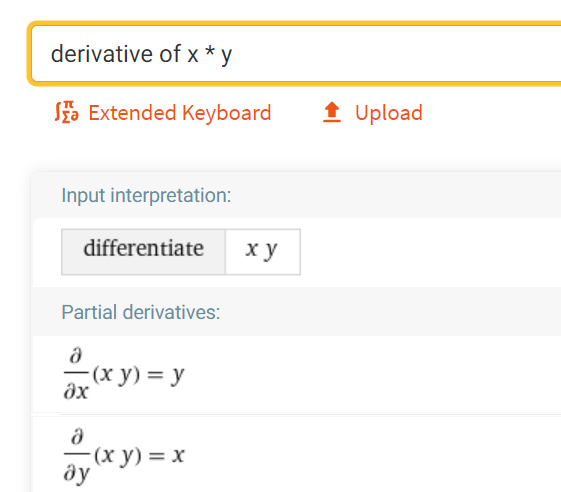

So we see now there are actually two derivatives, one with respect to $x$ and the other to $y$. The actual value itself is pretty simple too, the derivative of $f(x, y)$ with respect to $x$ is $y$. These derivatives can be combined via the chain rule to find the derivatives of more complex functions (like $f(x) = mx + b$, as we will see below).

This is all well and good, but let's see some code. It will help cement a bunch of the ideas above. The end goal here is to learn a simple function (i.e. for $f(x) = mx + b$, figure out $m$ and $b$ from only a list of values fo $x$ and the corresponding value of $f(x)$). First we need a class to wrap scalar values (scalar meaning a plain-ol' number) so we can track inputs and outputs to build a graph via eager computations.

In [1]:
class Scalar:
    def __init__(self, num, inputs=None, backward=None):
        self.num = num
        self.backward_fn = backward

        # If this scalar is the last node in a graph (i.e. has no inputs),
        # call it a leaf
        self.is_leaf = inputs is None
        if self.is_leaf:
            self.inputs = []
        else:
            self.inputs = inputs

        # Set a slot for the derivative
        self.derivative = None

This class takes in `num` which is the value it is wrapping. `inputs` is blank for any `Scalar`s we create, but operations will use this to record themselves on results. `Scalar`s therefore reference other `Scalar`s, creating a directed graph of operations. Lastly, `backward` is a callback we will see later. Next let's define a multiply operation by overriding the `__mul__` magic method.

In [2]:
class Scalar(Scalar):
    def __mul__(self, x):
        # Do the actual multiplication
        scalar_result = self.num * x.num

        def backward(b_in):
            return (x.num, self.num)

        return Scalar(num=scalar_result, inputs=(self, x), backward=backward)

The multiply operation looks a little different than what we talked out above. First off, it only takes in one input since the first input is the `Scalar` in `self`. `backward` is a function (really a closure since it's grabbing variables from the outer scope like `x` and `self`) that takes in the previous gradient (via the chain rule) as `b_in` and returns partial derivatives for each inputs. Just like the Wolfram Alpha result above, we return `x` as the derivative with respect to `self` and vice-versa. We do something similar for all other operations we need, which are subtraction, square, and add.

In [3]:
class Scalar(Scalar):
    def __add__(self, x):
        scalar_result = self.num + x.num

        def backward(b_in):
            return (1, 1)

        return Scalar(scalar_result, [self, x], backward)
    
    def __sub__(self, x):
        scalar_result = self.num - x.num

        def backward(b_in):
            return (1, -1)

        return Scalar(scalar_result, [self, x], backward)

    def square(self):
        scalar_result = self.num ** 2

        def backward(b_in):
            return (2 * self.num,)

        return Scalar(scalar_result, [self], backward)

Now we have all the operations we need to train a model (we'll see what that looks like in a minute) but how do we actually do the chain rule (i.e. what's the deal with all these `backward` functions)?

In [4]:
class Scalar(Scalar):
    def backward(self, b_in=1):
        if self.is_leaf:
            # If this Scalar is a leaf, there are no further derivatives to compute, so
            # set the derivative on this node
            self.derivative = b_in
            return

        backward_results = self.backward_fn(self.num)
        
        # Send gradient to each of the inputs
        for backward_result, input in zip(backward_results, self.inputs):
            input.backward(backward_result * b_in)

Now our `Scalar` class is fully defined and our machine learning "library" is done! Now we can use it in a real example. We will define a function `goal_function` that does some computation (here we happen to know exactly what it does since we wrote it, but it illustrates the principles). We use this to create some training data, examples for our model to learn from (since it doesn't know anything about `goal_function` directly.

In [5]:
def goal_function(x):
    return 5 * x + 10

# Scaling the data to be small is important!
training_data = [(i / 100, goal_function(i / 100)) for i in range(100)]

Finally we can train the model. We want to figure out the $m$ and $b$ in $y = mx + b$, so we set up `Scalar`s for both of those. We also set two "hyperparameters" that dictate how we will scale the "nudges" produced by our training (`learning_rate`), as well as how many times to run through the training process (`epochs`).

In [6]:
# Arbitrary initialization for our weights
m = Scalar(0)
b = Scalar(0)

# Hyperparameters
learning_rate = 0.001
epochs = 30

The training loop creates a `Scalar` and uses it to predict a value. It then calculates the `loss`, which represents the distance from the prediction to the actual value. Lastly it updates `m` and `b` with a new value from the derivatives of each (filled out via the `backward` function call).

In [7]:
# Training loop
for i in range(epochs):
    for input_x, actual_y in training_data:
        # Make prediction
        predicted_y = m * Scalar(input_x) + b

        # Calculate MSE loss
        loss = (Scalar(actual_y) - predicted_y).square()
        loss.backward()
        # Update m and b via gradient descent
        m = Scalar(m.num - learning_rate * m.derivative)
        b = Scalar(b.num - learning_rate * b.derivative)

    if i % 4 == 0:
        print(f"[epoch {i}] Estimated that m={round(m.num, 2)} and b={round(b.num, 2)}")

[epoch 0] Estimated that m=1.13 and b=2.23
[epoch 4] Estimated that m=3.63 and b=7.15
[epoch 8] Estimated that m=4.54 and b=8.94
[epoch 12] Estimated that m=4.87 and b=9.6
[epoch 16] Estimated that m=4.99 and b=9.83
[epoch 20] Estimated that m=5.03 and b=9.92
[epoch 24] Estimated that m=5.04 and b=9.95
[epoch 28] Estimated that m=5.04 and b=9.97


Pretty close, if you ask me! The model correctly figured out the `m` is 5-ish and `b` is 10-ish, which matches up with `goal_function` above. So we've created a simple framework for learning scalar linear functions, and validated that it works! Wow!